In [1]:
import os, time, random, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report
from collections import Counter, OrderedDict
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import Optimizer

# Reproducible seed
def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ.get('PYTHONHASHSEED') == str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Used device: {device}\nNumber of GPUs: {torch.cuda.device_count()}")

Used device: cuda
Number of GPUs: 2


In [2]:
df = pd.read_csv('/kaggle/input/emotweetid-human-labeled-dataset/EmoTweetID-Human.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,tweet,label
0,wah belom liat muka gue lagi murka hahahaha,joy
1,Mungkin kurang piknik adrenalin. Mereka yg ske...,anger
2,"maaf kalo tersinggung ""orang kurus cepet mati""...",anger
3,berserah pada maha esa paling tabah dan sabar ...,joy
4,Ehekk malu la hahahahahahaha,sadness


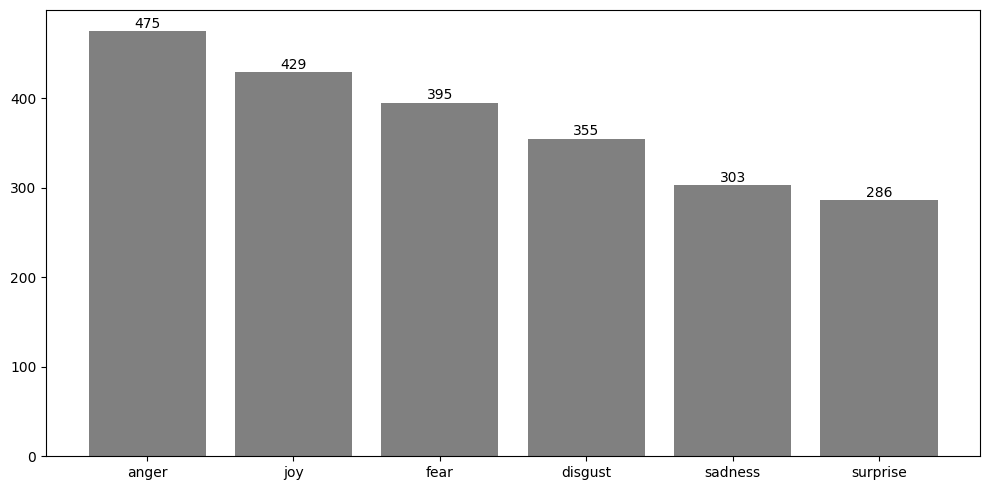

In [3]:
lc = df['label'].value_counts()
plt.figure(figsize=(10,5))
plt.bar(lc.index, lc.values, color='Gray')
for i, v in enumerate(lc.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show();

In [4]:
set_seed()
def text_preprocessing(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')
    return text.strip()

df['tweet'] = df['tweet'].apply(text_preprocessing)


vocab = set()
for tweet in df['tweet']:
    words = tweet.split()
    vocab.update(words)

# vocab = {word for phrase in df['tweet'] for word in phrase}
word_to_idx = {word: idx for idx, word in enumerate(vocab, start=1)}
word_to_idx['<PAD>'] = 0 # padding token (index 0) for any sequences shorter than max_length
word_to_idx['<UNK>'] = len(word_to_idx) # add unknown token to vocab

max_length = df['tweet'].apply(lambda x: len(x.split())).max()
print(f"Max sequence length (in words):{max_length} ")

def encode_and_pad(text):
    words = text.split()
    encoded = []
    
    for word in words:
        if word in word_to_idx:
            encoded.append(word_to_idx[word])
        else:
            encoded.append(word_to_idx['<UNK>']) # special unknown token

    # padding/truncation
    if len(encoded) < max_length:
        encoded += [word_to_idx['<PAD>']] * (max_length - len(encoded))
    else:
        encoded = encoded[:max_length]
    return encoded


df['tweet'] = df['tweet'].apply(encode_and_pad)

Max sequence length (in words):67 


In [5]:
class EmotDataset(Dataset):
    def __init__(self, df):
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(df['label'])))}
        self.labels = df['label'].map(self.label_to_idx)
        self.tweets = df['tweet'].values
    def __len__(self): 
        return len(self.tweets)
    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

dataset = EmotDataset(df)
print(f"Class labels: {dataset.label_to_idx}\nTotal Classes: {len(dataset.label_to_idx)}")

Class labels: {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}
Total Classes: 6


### RNN

In [6]:
class EmotRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(EmotRNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, layer_dim)
        self.rnn = nn.RNN(layer_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Last output
        return self.fc(out)

### LSTM

In [7]:
class EmotLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(EmotLSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, layer_dim)
        self.lstm = nn.LSTM(layer_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(x)
        out = lstm_out[:, -1, :]  # Last output (consistent with RNN/GRU)
        return self.fc(out)

### GRU

In [8]:
class EmotGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(EmotGRU, self).__init__()
        self.embedding = nn.Embedding(input_dim, layer_dim)
        self.gru = nn.GRU(layer_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        out = out[:, -1, :]  # Last output
        return self.fc(out)

### RUNNING EXPERIMENTS

In [9]:
def training_with_early_stopping(model, train_dl, val_dl, loss_fn, optimizer, epochs, device, patience=3):
    history = {
        'train_loss': [], 'train_acc': [], 
        'val_loss': [], 'val_acc': []
    }
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X.size(0)
            train_correct += (outputs.argmax(1) == y).sum().item()
            train_total += X.size(0)
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.inference_mode():
            for X, y in val_dl:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                val_loss += loss_fn(outputs, y).item() * X.size(0) 
                val_correct += (outputs.argmax(1) == y).sum().item()
                val_total += X.size(0)
        
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_weights = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_weights)
                break
    
    return history

In [10]:
# def test_models(models):
#     train_dl = DataLoader(dataset, batch_size=4, shuffle=True)
#     X_batch, y_batch = next(iter(train_dl))
    
#     print(f"Input shape: {X_batch.shape}")  # Should be (4, max_length)
#     for model in models:
#         model_name = model.__class__.__name__
#         model.eval()
#         with torch.inference_mode():
#             output = model(X_batch)
#             print(f"Model Name: {model_name}")
#             print(f"Output shape: {output.shape}")  # Should be (4, 6)
#             print(f"Output: {output}")
    
#     return models

# # Run test
# kwargs = (input_dim, hidden_dim, layer_dim, output_dim)
# test_models = test_models([EmotGRU(*kwargs), EmotRNN(*kwargs), EmotLSTM(*kwargs)])

In [11]:
input_dim = len(vocab) + 1
layer_dim = 64 # embedding size
hidden_dim = 128 # size of network
output_dim = 6 # dataset's class length
epochs = 30
loss_fn = torch.nn.CrossEntropyLoss()

model_kwargs = {'input_dim': input_dim, 
                'hidden_dim': hidden_dim, 
                'layer_dim': layer_dim, 
                'output_dim': output_dim}

### -- METRICS

In [12]:
def compute_performance_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'predictions': all_preds,
        'labels': all_labels
    }

In [13]:
def comprehensive_cross_validate(model_class, model_args, dataset, loss_fn, epochs, device, k=5):
    """Pass model class and arguments instead of model instance"""
    labels = df['label'].values
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
    cv_results = {
        'fold_train_acc': [], 'fold_val_acc': [],
        'fold_train_f1_macro': [], 'fold_val_f1_macro': [],
        'fold_train_f1_weighted': [], 'fold_val_f1_weighted': [],
        'training_time': [], 'epochs_used': [],
        'all_val_predictions': [], 'all_val_labels': []
    }    
    for fold, (train_idx, val_idx) in enumerate(skf.split(df, labels)):
        print(f"\n=== Fold {fold+1}/{k} ===")
        print(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
        start_time = time.time()

        train_dl = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_idx))
        val_dl = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(val_idx))

        model = model_class(**model_args).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        history = training_with_early_stopping(model, train_dl, val_dl, loss_fn, optimizer, epochs, device, patience=5)

        fold_time = time.time() - start_time
    
        train_metrics = compute_performance_metrics(model, train_dl, device)
        val_metrics = compute_performance_metrics(model, val_dl, device)
        
        # Store results
        cv_results['fold_train_acc'].append(train_metrics['accuracy'])
        cv_results['fold_val_acc'].append(val_metrics['accuracy'])
        cv_results['fold_train_f1_macro'].append(train_metrics['f1_macro'])
        cv_results['fold_val_f1_macro'].append(val_metrics['f1_macro'])
        cv_results['fold_train_f1_weighted'].append(train_metrics['f1_weighted'])
        cv_results['fold_val_f1_weighted'].append(val_metrics['f1_weighted'])
        cv_results['training_time'].append(fold_time)
        cv_results['epochs_used'].append(len(history['val_acc']))
        cv_results['all_val_predictions'].extend(val_metrics['predictions'])
        cv_results['all_val_labels'].extend(val_metrics['labels'])
        
        print(f"Fold {fold+1} completed in {fold_time:.2f}s")
        print(f"Train Acc: {train_metrics['accuracy']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
        print(f"Train F1-macro: {train_metrics['f1_macro']:.4f}, Val F1-macro: {val_metrics['f1_macro']:.4f}")
    
    return cv_results

In [14]:
def measure_efficiency(model, input_shape=(32,67), device=device):
    model.eval()

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # inference time
    dummy_input = torch.randint(0, 1000, input_shape).to(device)
    # Warmup
    for _ in range(10):
        _ = model(dummy_input)
    
    # Measure inference time
    starter = torch.cuda.Event(enable_timing=True)
    ender = torch.cuda.Event(enable_timing=True)
    times = []
    
    with torch.no_grad():
        for _ in range(100):
            starter.record()
            _ = model(dummy_input)
            ender.record()
            torch.cuda.synchronize()
            times.append(starter.elapsed_time(ender))
    
    # Memory usage (peak during inference)
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        _ = model(dummy_input)
        memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)  # Convert to MB
    
    return {
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'inference_time_ms': np.mean(times),
        'inference_std_ms': np.std(times),
        'gpu_memory_mb': memory_used if torch.cuda.is_available() else 0,
        'parameters_millions': total_params / 1e6
    }

In [15]:
def run_complete_ablation_study():
    """Run comprehensive ablation study for all models"""
    
    # Model configurations
    model_configs = {
        'RNN': {'class': EmotRNN, 'args': {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'layer_dim': layer_dim, 'output_dim': output_dim}},
        'LSTM': {'class': EmotLSTM, 'args': {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'layer_dim': layer_dim, 'output_dim': output_dim}},
        'GRU': {'class': EmotGRU, 'args': {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'layer_dim': layer_dim, 'output_dim': output_dim}},
        # Add more variants here for ablation
    }
    
    results = {}
    
    for model_name, config in model_configs.items():
        print(f"\n{'='*50}")
        print(f"TESTING {model_name}")
        print(f"{'='*50}")
        
        # 1. Performance Evaluation
        print("1. Performance Evaluation...")
        cv_results = comprehensive_cross_validate(
            config['class'], config['args'], dataset, loss_fn, epochs, device=device, k=5
        )
        
        # 2. Efficiency Evaluation
        print("2. Efficiency Evaluation...")
        model_instance = config['class'](**config['args']).to(device)
        efficiency = measure_efficiency(model_instance, device=device)
        
        
        # Store all results
        results[model_name] = {
            'performance': cv_results,
            'efficiency': efficiency,
            'model': model_instance
        }
    
    return results

# Run the complete study
ablation_results = run_complete_ablation_study()


TESTING RNN
1. Performance Evaluation...

=== Fold 1/5 ===
Train samples: 1794, Val samples: 449
Epoch 1: Train Loss: 1.8028, Train Acc: 0.1918, Val Loss: 1.7860, Val Acc: 0.2116
Epoch 2: Train Loss: 1.7934, Train Acc: 0.1996, Val Loss: 1.7834, Val Acc: 0.2116
Epoch 3: Train Loss: 1.7898, Train Acc: 0.2079, Val Loss: 1.7860, Val Acc: 0.1915
Epoch 4: Train Loss: 1.7834, Train Acc: 0.2057, Val Loss: 1.7770, Val Acc: 0.2116
Epoch 5: Train Loss: 1.7825, Train Acc: 0.2157, Val Loss: 1.7872, Val Acc: 0.1915
Epoch 6: Train Loss: 1.7826, Train Acc: 0.2023, Val Loss: 1.7814, Val Acc: 0.1759
Epoch 7: Train Loss: 1.7823, Train Acc: 0.2029, Val Loss: 1.7801, Val Acc: 0.2116
Epoch 8: Train Loss: 1.7827, Train Acc: 0.2007, Val Loss: 1.7787, Val Acc: 0.2116
Epoch 9: Train Loss: 1.7820, Train Acc: 0.1990, Val Loss: 1.7772, Val Acc: 0.2116
Early stopping at epoch 9
Fold 1 completed in 10.44s
Train Acc: 0.2124, Val Acc: 0.2116
Train F1-macro: 0.0593, Val F1-macro: 0.0582

=== Fold 2/5 ===
Train samples

In [16]:
def generate_ablation_report(ablation_results):
    """Generate comprehensive ablation study report"""
    
    performance_table = []
    efficiency_table = []
    
    for model_name, results in ablation_results.items():
        perf = results['performance']
        eff = results['efficiency']
        
        # Performance table
        performance_table.append({
            'Model': model_name,
            'Val Accuracy': f"{np.mean(perf['fold_val_acc']):.3f} ± {np.std(perf['fold_val_acc']):.3f}",
            'Val F1-Macro': f"{np.mean(perf['fold_val_f1_macro']):.3f} ± {np.std(perf['fold_val_f1_macro']):.3f}",
            'Val F1-Weighted': f"{np.mean(perf['fold_val_f1_weighted']):.3f} ± {np.std(perf['fold_val_f1_weighted']):.3f}",
            'Training Time (s)': f"{np.mean(perf['training_time']):.1f}",
            'Epochs to Converge': f"{np.mean(perf['epochs_used']):.1f}"
        })
        
        # Efficiency table
        efficiency_table.append({
            'Model': model_name,
            'Params (M)': f"{eff['parameters_millions']:.2f}",
            'Inference Time (ms)': f"{eff['inference_time_ms']:.2f} ± {eff['inference_std_ms']:.2f}",
            'GPU Memory (MB)': f"{eff['gpu_memory_mb']:.1f}"
        })

    print("📊 PERFORMANCE COMPARISON")
    print(pd.DataFrame(performance_table))
    
    print("\n⚡ EFFICIENCY COMPARISON")  
    print(pd.DataFrame(efficiency_table))
    
    return {
        'performance': pd.DataFrame(performance_table),
        'efficiency': pd.DataFrame(efficiency_table)
    }

# Generate final report
final_report = generate_ablation_report(ablation_results)

📊 PERFORMANCE COMPARISON
  Model   Val Accuracy   Val F1-Macro Val F1-Weighted Training Time (s)  \
0   RNN  0.204 ± 0.010  0.057 ± 0.003   0.070 ± 0.007               3.7   
1  LSTM  0.212 ± 0.000  0.058 ± 0.000   0.074 ± 0.000               2.7   
2   GRU  0.633 ± 0.021  0.626 ± 0.028   0.630 ± 0.024               3.1   

  Epochs to Converge  
0                9.4  
1               12.2  
2               14.2  

⚡ EFFICIENCY COMPARISON
  Model Params (M) Inference Time (ms) GPU Memory (MB)
0   RNN       0.59         0.44 ± 0.02            36.2
1  LSTM       0.67         0.63 ± 0.04            55.8
2   GRU       0.64         0.58 ± 0.03            51.8


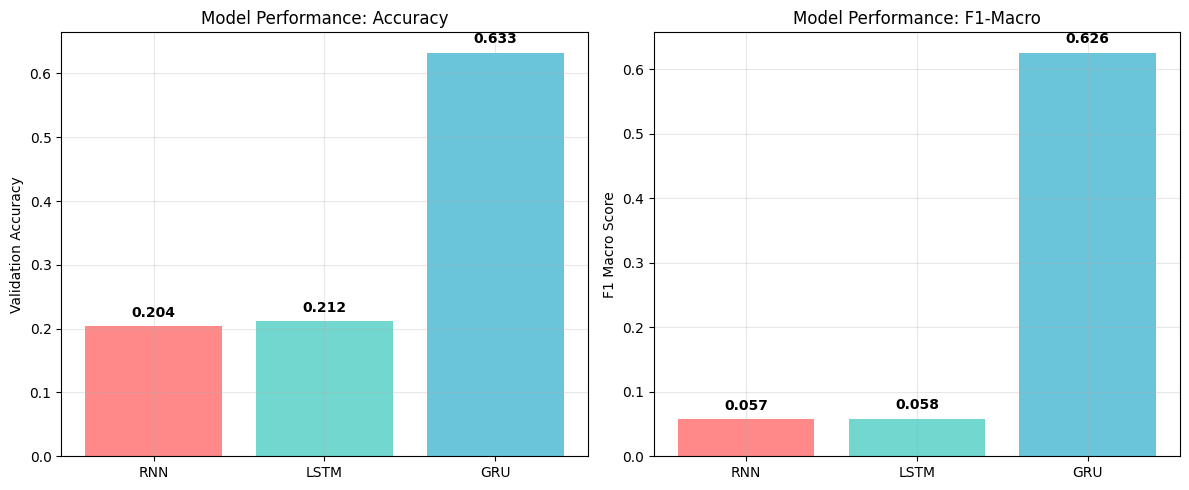

In [17]:
def plot_performance_comparison(ablation_results):
    """Bar chart comparing model performance - ESSENTIAL for papers"""
    models = list(ablation_results.keys())
    val_accs = [np.mean(results['performance']['fold_val_acc']) for results in ablation_results.values()]
    val_f1s = [np.mean(results['performance']['fold_val_f1_macro']) for results in ablation_results.values()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Accuracy comparison
    bars1 = ax1.bar(models, val_accs, color=['#ff6b6b', '#4ecdc4', '#45b7d1'], alpha=0.8)
    ax1.set_ylabel('Validation Accuracy')
    ax1.set_title('Model Performance: Accuracy')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars1, val_accs):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # F1-score comparison
    bars2 = ax2.bar(models, val_f1s, color=['#ff6b6b', '#4ecdc4', '#45b7d1'], alpha=0.8)
    ax2.set_ylabel('F1 Macro Score')
    ax2.set_title('Model Performance: F1-Macro')
    ax2.grid(True, alpha=0.3)
    
    for bar, f1 in zip(bars2, val_f1s):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Usage
plot_performance_comparison(ablation_results)

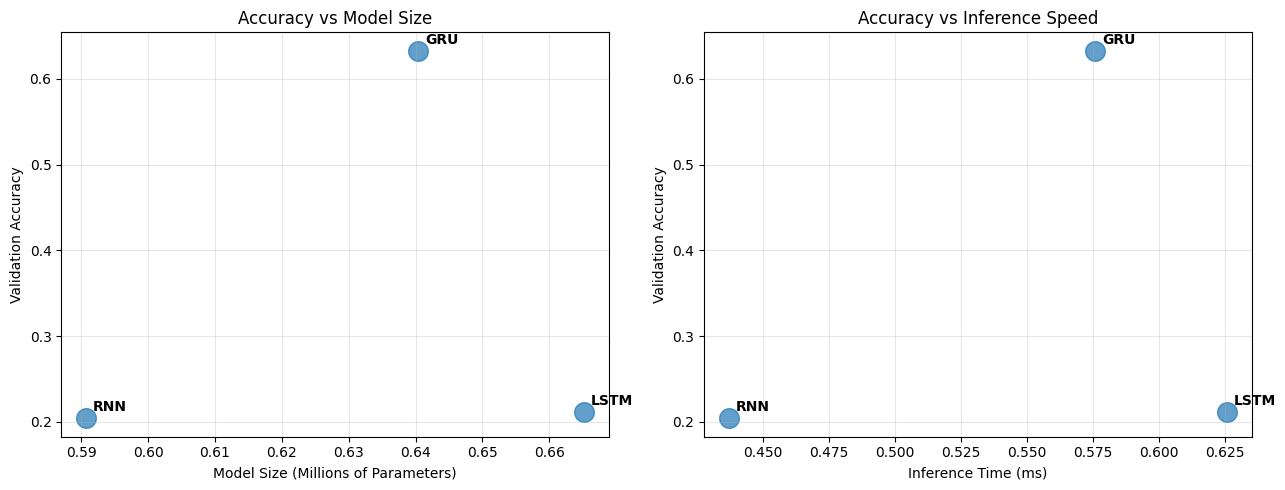

In [18]:
def plot_efficiency_vs_performance(ablation_results):
    """Classic efficiency-performance trade-off plot"""
    models = list(ablation_results.keys())
    
    # Extract data
    performances = [np.mean(results['performance']['fold_val_acc']) for results in ablation_results.values()]
    parameters = [results['efficiency']['parameters_millions'] for results in ablation_results.values()]
    inference_times = [results['efficiency']['inference_time_ms'] for results in ablation_results.values()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    
    # Parameters vs Performance
    scatter1 = ax1.scatter(parameters, performances, s=200, alpha=0.7)
    ax1.set_xlabel('Model Size (Millions of Parameters)')
    ax1.set_ylabel('Validation Accuracy')
    ax1.set_title('Accuracy vs Model Size')
    ax1.grid(True, alpha=0.3)
    
    # Add model labels
    for i, model in enumerate(models):
        ax1.annotate(model, (parameters[i], performances[i]), 
                    xytext=(5, 5), textcoords='offset points', fontweight='bold')
    
    # Inference Time vs Performance
    scatter2 = ax2.scatter(inference_times, performances, s=200, alpha=0.7)
    ax2.set_xlabel('Inference Time (ms)')
    ax2.set_ylabel('Validation Accuracy')
    ax2.set_title('Accuracy vs Inference Speed')
    ax2.grid(True, alpha=0.3)
    
    for i, model in enumerate(models):
        ax2.annotate(model, (inference_times[i], performances[i]), 
                    xytext=(5, 5), textcoords='offset points', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_efficiency_vs_performance(ablation_results)

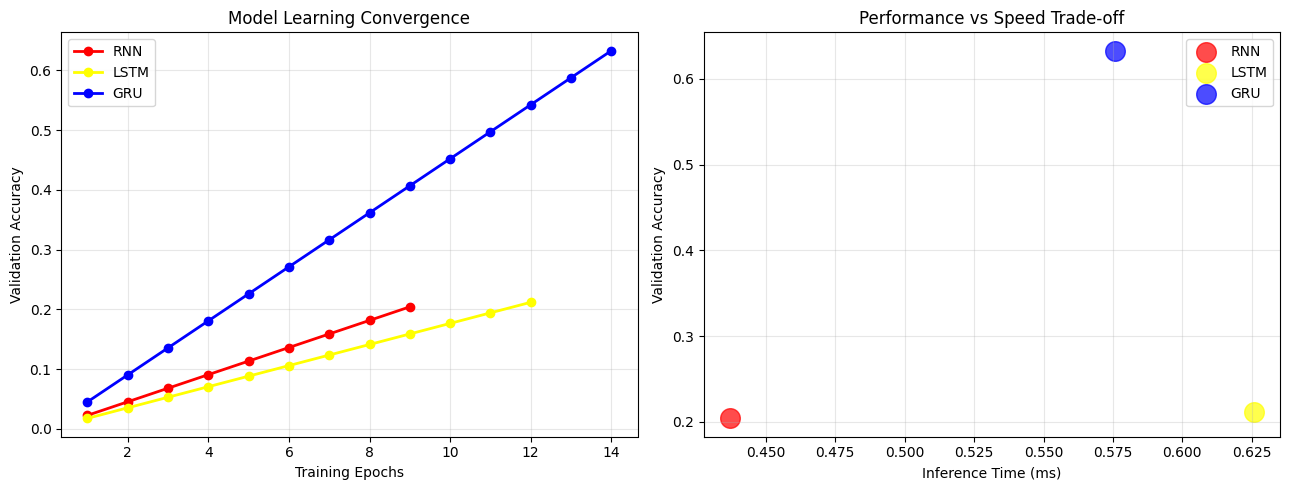

In [19]:
def plot_training_curves_comparison(ablation_results):
    """Show how different models learn over time"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    
    colors = {'RNN': 'Red', 'LSTM': 'Yellow', 'GRU': 'Blue'}
    
    for model_name, results in ablation_results.items():
        perf = results['performance']
        
        # Plot accuracy convergence
        epochs_used = int(np.mean(perf['epochs_used']))
        epochs_range = range(1, epochs_used + 1)
        
        # Use average final performance as reference
        final_acc = np.mean(perf['fold_val_acc'])
        
        ax1.plot(epochs_range, [final_acc * (i/epochs_used) for i in epochs_range], 
                label=model_name, color=colors[model_name], linewidth=2, marker='o')
        
        # Plot efficiency trade-off
        ax2.scatter(results['efficiency']['inference_time_ms'], 
                   np.mean(perf['fold_val_acc']), 
                   s=200, label=model_name, color=colors[model_name], alpha=0.7)
    
    ax1.set_xlabel('Training Epochs')
    ax1.set_ylabel('Validation Accuracy')
    ax1.set_title('Model Learning Convergence')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.set_xlabel('Inference Time (ms)')
    ax2.set_ylabel('Validation Accuracy')
    ax2.set_title('Performance vs Speed Trade-off')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_curves_comparison(ablation_results)

In [20]:
def create_publication_table(ablation_results):
    """Create a publication-ready results table"""
    table_data = []
    
    for model_name, results in ablation_results.items():
        perf = results['performance']
        eff = results['efficiency']
        
        table_data.append({
            'Model': model_name,
            'Val Accuracy': f"{np.mean(perf['fold_val_acc']):.3f} ± {np.std(perf['fold_val_acc']):.3f}",
            'Val F1-Macro': f"{np.mean(perf['fold_val_f1_macro']):.3f} ± {np.std(perf['fold_val_f1_macro']):.3f}",
            'Params (M)': f"{eff['parameters_millions']:.2f}",
            'Inference (ms)': f"{eff['inference_time_ms']:.2f}",
            'Training Time (s)': f"{np.mean(perf['training_time']):.1f}",
            'Epochs to Converge': f"{np.mean(perf['epochs_used']):.1f}"
        })
    
    df = pd.DataFrame(table_data)
    
    # Style the table for publication
    styled_df = df.style.set_properties(**{
        'text-align': 'center',
        'font-size': '12pt'
    }).set_table_styles([{
        'selector': 'th',
        'props': [('font-size', '14pt'), ('font-weight', 'bold')]
    }]).hide(axis='index')
    
    print("📊 PUBLICATION-READY RESULTS TABLE")
    print("="*80)
    display(styled_df)
    
    return df

results_table = create_publication_table(ablation_results)

📊 PUBLICATION-READY RESULTS TABLE


Model,Val Accuracy,Val F1-Macro,Params (M),Inference (ms),Training Time (s),Epochs to Converge
RNN,0.204 ± 0.010,0.057 ± 0.003,0.59,0.44,3.7,9.4
LSTM,0.212 ± 0.000,0.058 ± 0.000,0.67,0.63,2.7,12.2
GRU,0.633 ± 0.021,0.626 ± 0.028,0.64,0.58,3.1,14.2
